**Table of Contents:**

>[About task](#scrollTo=Oga1CrB_y5qt)

>[Required libraries](#scrollTo=Zly2NxPd3Sgx)

>[Dataset](#scrollTo=4ULTOoDR3eP0)

>[Quantum Circuit as a Convolutional Layer](#scrollTo=ko2GnWk4sYEx)

>[Hybrid model](#scrollTo=tC8R0ymD3oqD)

>[Performance](#scrollTo=5sSiZ4XvzQk0)

>[References](#scrollTo=grXx-hQWwPN-)



# About task
---
This Notebook is an extension of my previous notebooks: task_3 and task_5.1_cnn. My contributions to this notebook include:

- **Preprocessing**: The actual dataset contains 6 classes of 22,638 training data and 5,581 testing data. This time I choose only two classes: good weld(0), and burn through(1). As resource constraints, the images were resized from 800x974 to 32x32 and, the model was trained with only 100 training data, from which 10% data was used to validate the training process. And lastly 50 data for testing from the testing set for final testing. Furthermore, I trained the model with only 5 epochs, as I chose lower data


- **3x3 kernel:** Implemented a 3x3 kernel for the Quantum Convolutional layer. As the 3x3 kernel has 9 elements. So I needed a 9-qubit system. (from task_3)

- **Ansatz(e):** 4 Strongly Entangling layers(with CZ as imprimitive) are used as ansatze. A 1 layer system could do the work, but as I see in task_4, more layers give access to more Hilbert space, leading to lower cost and better accuracy. (from task_3)

- **Custom hybrid model:** The quantum circuit is used as a convolutional layer and produces 15x15x9 dimensions of features. Which is then fed to the classical CNN. For the classical part, a Convolutional 3x3 kernel with 64 channels, followed by a maxpooling2D 2x2 filter is implemented. A dense layer with 64 nodes is applied before the 2 classifying dense nodes, and a dropout of 50% is imposed in the middle to handle the overfitting issue.

- **Quantum Circuit as a layer**: This time I combined the Quantum Circuit with the Classical CNN model. I used tf.py_function to wrap the output from the quantum circuit to tensorflow and implemented a new layer, QuantumConv2D.  Furthermore, I modified the model to handle data from batch mode.

- **Hyper-Parameter Tuning:** ReduceLROnPlateau was iplemented to optimize the learning rate, and CSVLogger was used to record the training process. The best-performing model was saved in Keras format and used to measure the performance with testing data. (from task_5.1_cnn)

- **Performance Measurements:** Overall Accuracy (OA), Average Accuracy (AA), Kappa, Precision, Recall, Specificity, and F1 Score were implemented to measure the model performance.


# Required libraries

In [1]:
import json
import os
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.utils import shuffle
from collections import Counter

import zipfile
import shutil
import cv2

import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from keras import models
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, CSVLogger

from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
from google.colab import userdata
os.environ["KAGGLE_KEY"] = userdata.get('key')
os.environ["KAGGLE_USERNAME"] = userdata.get('username')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import warnings
warnings.filterwarnings('ignore')

# Dataset

In [5]:
! kaggle datasets download -d danielbacioiu/tig-aluminium-5083

! unzip -q "tig-aluminium-5083.zip"

Dataset URL: https://www.kaggle.com/datasets/danielbacioiu/tig-aluminium-5083
License(s): CC-BY-SA-4.0
tig-aluminium-5083.zip: Skipping, found more recently modified local copy (use --force to force download)
replace al5083/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
'''
In this work, we will choose only two classes: good_weld:0, and burn_through:1

from README
-------------------------
Multiclass labels
-------------------------
good weld           0
burn through        1
contamination       2
lack of fusion      3
misalignment        4
lack of penetration 5

'''
# configs
n_train = 100    # Size of the train set
n_test = 50     # Size of the test set
n_epochs = 5
batch_size = 8
img_size = 32
labels = {0:'good_weld', 1:'burn_through', 2:'contamination', 3:'lack_of_fusion', 4:'misalignment', 5:'lack_of_penetration'}
classes = ['good_weld', 'burn_through', 'contamination', 'lack_of_fusion', 'misalignment', 'lack_of_penetration']

PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [7]:
loc = "/content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_5"
Exp = "task_5.2_hybrid-II"

In [8]:
root_path = '/content/al5083/'
# Opening JSON file
f1 = open(root_path + 'train/train.json')
f2 = open(root_path + 'test/test.json')

tr_data = json.load(f1)
te_data = json.load(f2)

In [9]:
X_train = []
y_train = []

X_test = []
y_test = []

# choosing 2 classes only: good_weld(0) vs burn_through(1)
counter_0 = 0
counter_1 = 0
for file_path, label in tr_data.items():
    img_path = os.path.join(root_path, 'train', file_path)

    # getting equal number of classes
    if label == 0 and counter_0 < (n_train//2):
        # print('train - counter_0: ',counter_0)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))

        X_train.append(img)
        y_train.append(label)

        counter_0 += 1

    elif label == 1 and counter_1 < (n_train//2):
        # print('train - counter_1: ',counter_1)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))

        X_train.append(img)
        y_train.append(label)

        counter_1 += 1

counter_0 = 0
counter_1 = 0
for file_path, label in te_data.items():
    img_path = os.path.join(root_path, 'test', file_path)

    # getting equal number of classes
    if label == 0 and counter_0 < (n_test//2):
        # print('test - counter_0: ',counter_0)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))

        X_test.append(img)
        y_test.append(label)

        counter_0 += 1

    elif label == 1 and counter_1 < (n_test//2):
        # print('test - counter_1: ',counter_1)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))

        X_test.append(img)
        y_test.append(label)

        counter_1 += 1

# Closing file handle
f1.close()
f2.close()

In [10]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [11]:
# One Hot Encoding

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [12]:
X_train = X_train.reshape((X_train.shape[0],img_size,img_size,1))
X_test = X_test.reshape((X_test.shape[0],img_size,img_size,1))

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(100, 32, 32, 1) (100, 2)
(50, 32, 32, 1) (50, 2)


In [14]:
X_train[0].shape

(32, 32, 1)

In [15]:
# Let's shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=92)
X_test, y_test = shuffle(X_test, y_test, random_state=92)

In [16]:
def show_few_images(X = X_train, y = y_train, class_mapping = labels, number_of_examples=2, predict_using_model=None, distance_factor=0.5):
    num_classes = y.shape[1]
    figure1, ax1 = plt.subplots(number_of_examples, num_classes, figsize=(20, 5*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0

    for i in range(num_classes):
        # Find indices where the i-th class is 1 (true)
        class_indices = np.where(y[:, i] == 1)[0]
        if len(class_indices) > 0:
            # Sort the indices to ensure consistent spacing
            class_indices.sort()

            # Calculate the step size for index selection
            step = max(1, int(len(class_indices) * distance_factor))

            for j in range(number_of_examples):
                # Select an index with a large step size
                index = (j * step) % len(class_indices)
                selected_index = class_indices[index]

                image = X[selected_index]

                ax1[axs].imshow(image.squeeze(), cmap="gray")
                true_class = class_mapping[i]
                title = f'True: {true_class}'

                if predict_using_model:
                    result = predict_using_model.predict(np.expand_dims(image, axis=0))
                    acc = str(round(np.max(result)*100, 3))
                    predicted_classname = class_mapping[np.argmax(result)]
                    title += f'\nPrediction: {predicted_classname} - {acc}%'

                ax1[axs].set_title(title)
                axs += 1
        else:
            ax1[axs].set_title(f'No images for class {class_mapping[i]}')
            axs += 1

    plt.tight_layout()
    plt.savefig(f"{loc}/Figures/{Exp}_example_images.jpg", dpi=300, bbox_inches='tight')

    plt.show()

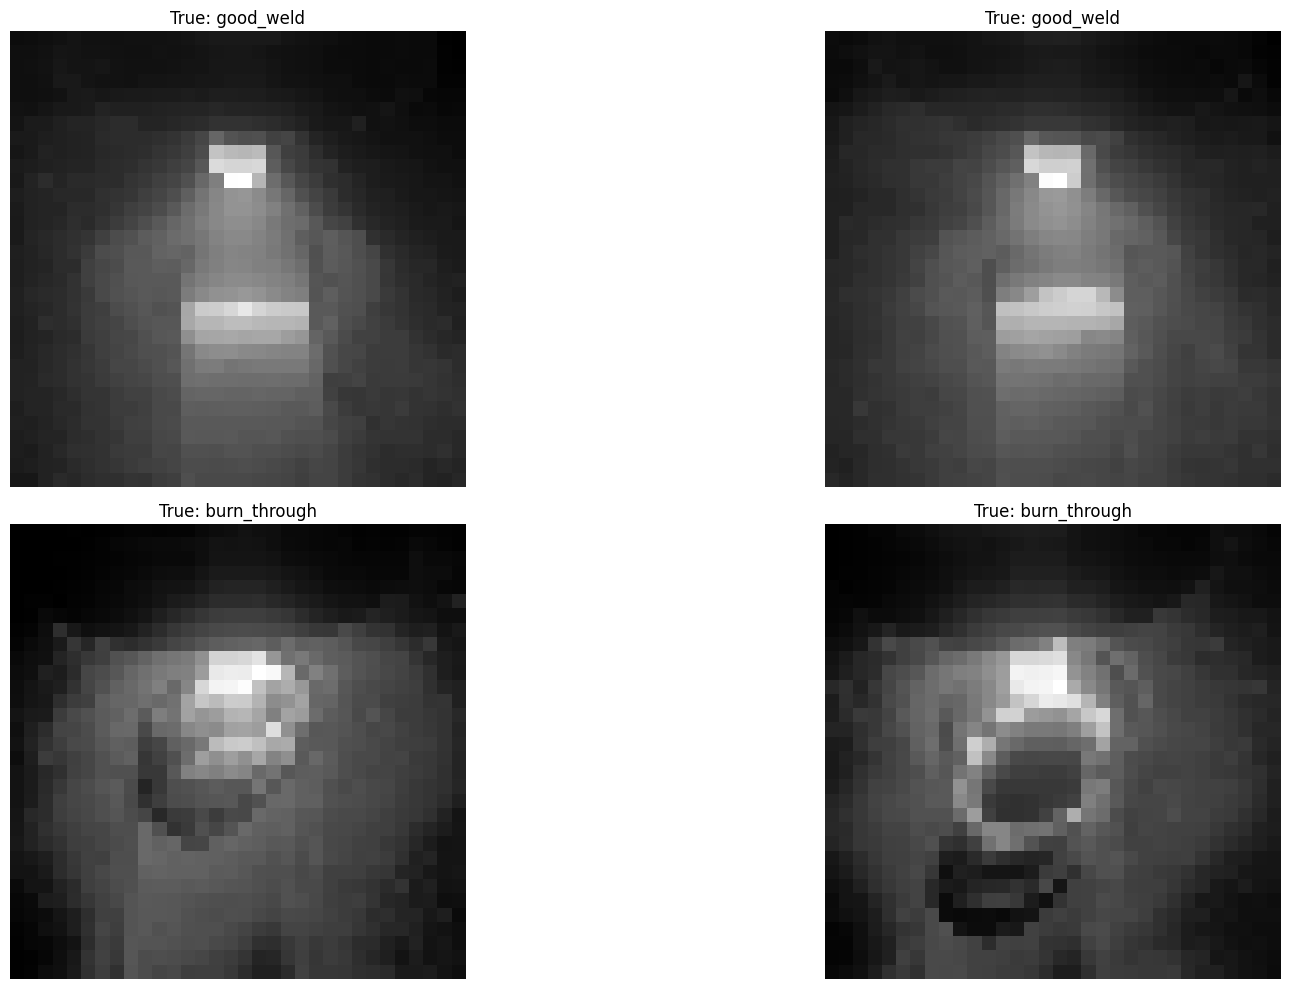

In [17]:
show_few_images(number_of_examples=2)

# Quantum Circuit as a Convolutional Layer

In [18]:
!pip install pennylane -q

In [19]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

In [20]:
# from task_3
n_layers = 4
n_wires = 9
dev = qml.device("lightning.qubit", wires=n_wires)

# Strongly Entangling Layer parameters
s_e_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_wires, 3))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 9 classical input values
    for j in range(n_wires):
        qml.RY(np.pi * phi[j], wires=j)

    # Strongly Entangling Layer
    qml.StronglyEntanglingLayers(s_e_params, wires=list(range(9)), imprimitive=qml.ops.CZ)

    # Measurement producing 9 classical output values for 9 channels
    return [qml.expval(qml.PauliZ(j)) for j in range(n_wires)]

(<Figure size 5200x1000 with 1 Axes>, <Axes: >)

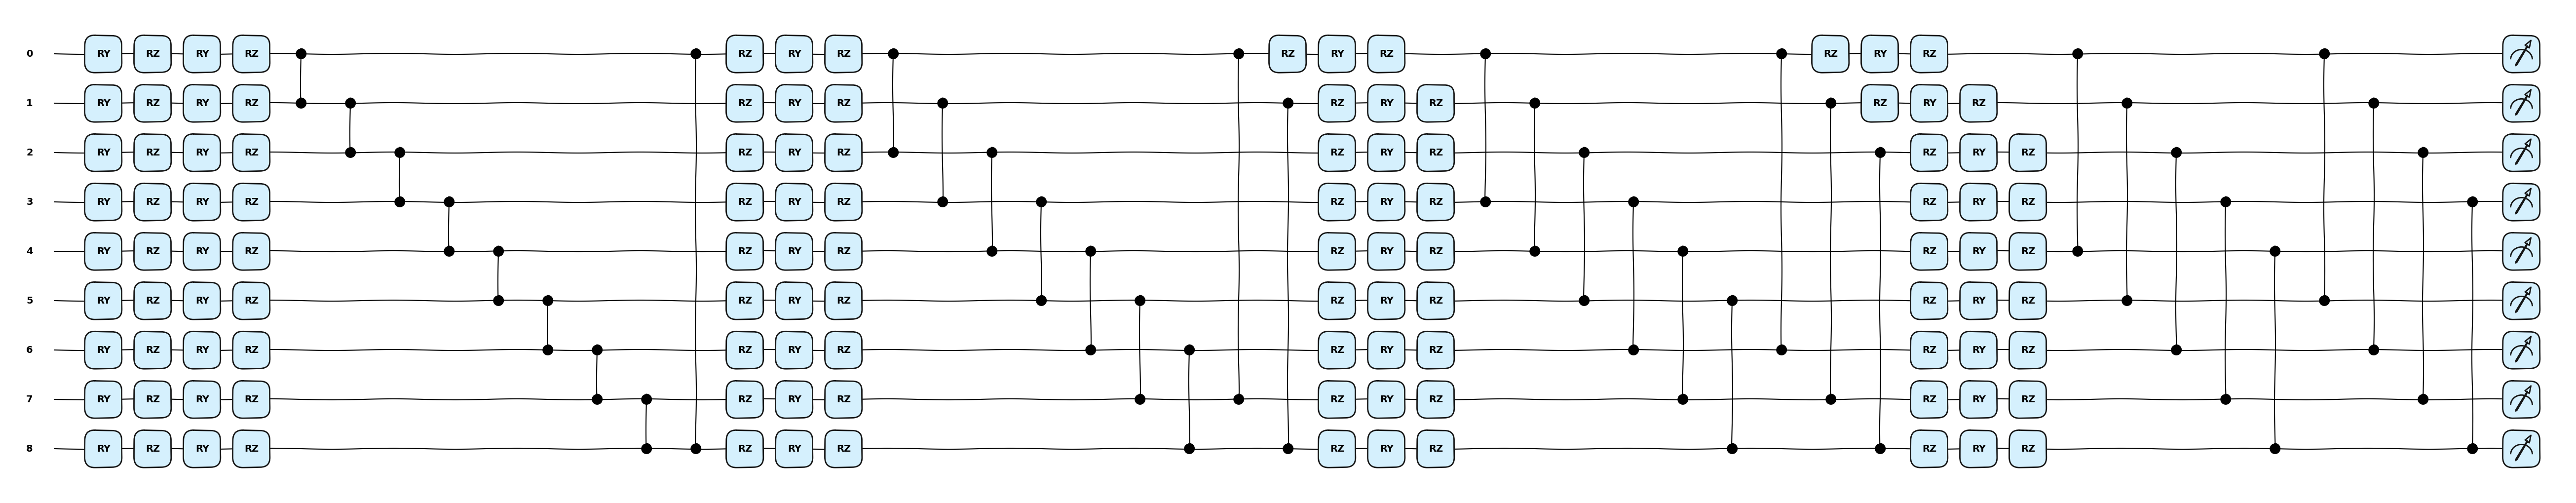

In [21]:
# Drawing circuit
qml.drawer.use_style('pennylane_sketch')
qml.draw_mpl(circuit, expansion_strategy="device")([i for i in range(n_wires)])

In [22]:
# A 3x3 kernel with stride = 2
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((img_size//2-1, img_size//2-1, 9))  # 9 output channels for 3x3 kernel

    # Loop over the coordinates of the top-left pixel of 3x3 squares
    for j in range(0, img_size - 2, 2):
        for k in range(0, img_size - 2, 2):
            # Process a 3x3 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],     image[j, k+1, 0],     image[j, k+2, 0],
                    image[j+1, k, 0],   image[j+1, k+1, 0],   image[j+1, k+2, 0],
                    image[j+2, k, 0],   image[j+2, k+1, 0],   image[j+2, k+2, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j, k)
            for c in range(len(q_results)):
                out[j//2, k//2, c] = q_results[c]
    return out

In [23]:
# Custom QuantumConv2D layer
class QuantumConv2D(Layer):
    def __init__(self, **kwargs):
        super(QuantumConv2D, self).__init__(**kwargs)

    def call(self, inputs):
        def process_batch(image_batch):
            return np.array([quanv(image) for image in image_batch])

        # wrapping the output from Quantum Circuit to tensorflow
        outputs = tf.py_function(func=process_batch, inp=[inputs], Tout=tf.float32)

        # Set the shape of the output tensor
        output_shape = (inputs.shape[0], img_size//2-1, img_size//2-1, 9)
        outputs.set_shape(output_shape)
        return outputs

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        return (batch_size, img_size//2-1, img_size//2-1, 9)

# Hybrid model

In [24]:
def build_model(input_shape=(img_size, img_size, 1), n_classes = 2, optimizer='adam'):

    sequential_model = Sequential([
            QuantumConv2D(input_shape=input_shape, name="QuantumConv"),

            layers.Conv2D(64, (3, 3), activation="relu", name="Conv2"),
            layers.MaxPooling2D(pool_size=(2, 2), name="Max_Pool_2"),

            layers.Flatten(),
            layers.Dense(64, activation="relu", name="fc1"),
            layers.Dropout(0.5),
            layers.Dense(n_classes, activation="softmax", name="fc2")

    ])
    sequential_model.compile(
                  optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    return sequential_model
qcnn_model = build_model()
qcnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ QuantumConv (QuantumConv2D)          │ (None, 15, 15, 9)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 13, 13, 64)          │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_2 (MaxPooling2D)            │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,898 (597.26 KB)

 Trainable params: 152,898 (597.26 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
checkpoint_path = f"{loc}/Models/{Exp}.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    # To save the best performing model
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       verbose=1,
                                       save_best_only=True,
                                       monitor = 'val_loss',
                                       mode='min'),

    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.8,
                                        patience=5,
                                        cooldown=1,
                                        verbose=1,
                                        mode='auto',
                                        min_lr=1e-4,
                                        min_delta=0.0001),
    # tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    CSVLogger(f"{loc}/Models/{Exp}.log", separator=',', append=False)
]

In [26]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.1
)
test_datagen = ImageDataGenerator(
        rescale=1./255
)


train_ds = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True,
  batch_size=batch_size)


In [27]:
val_ds = train_datagen.flow(
  X_train, y_train,
  subset="validation",
  shuffle=True,
  batch_size=batch_size)


In [28]:
test_ds = test_datagen.flow(
  X_test, y_test,
  shuffle=False,
  batch_size=batch_size)


In [29]:
history = qcnn_model.fit(train_ds,
                               epochs=n_epochs,
                               verbose=1,
                               validation_data = val_ds,
                               callbacks=callbacks)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 57s/step - acc: 0.5851 - loss: 0.6651 
Epoch 1: val_loss improved from inf to 0.42656, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_5/Models/task_5.2_hybrid-II.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 800s 64s/step - acc: 0.5948 - loss: 0.6603 - val_acc: 1.0000 - val_loss: 0.4266 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 61s/step - acc: 0.9439 - loss: 0.3588  
Epoch 2: val_loss improved from 0.42656 to 0.16510, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_5/Models/task_5.2_hybrid-II.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 807s 68s/step - acc: 0.9439 - loss: 0.3554 - val_acc: 1.0000 - val_loss: 0.1651 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 54s/step - acc: 0.9635 - loss: 0.1839 
Epoch 3: val_loss improved from 0.16510 to 0.04323, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_5/Models/task_5.2_hybrid-II.keras
12/12 ━━━

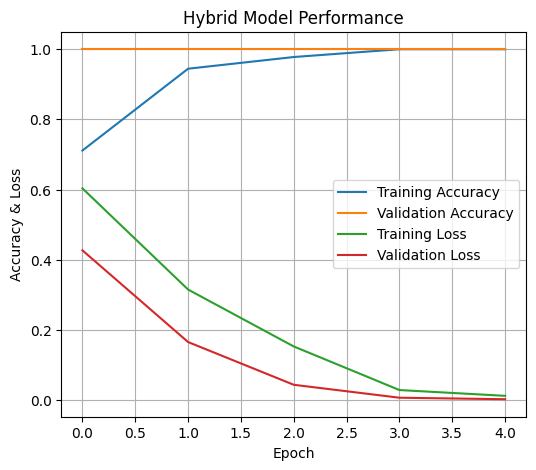

In [37]:
history = pd.read_csv(f"{loc}/Models/{Exp}.log", sep=',', engine='python')

############### ########## ####### #######

acc=history['acc']
val_acc=history['val_acc']

loss = history['loss']
val_loss = history['val_loss']


epochs_range=range(len(acc))

plt.figure(figsize=(6, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title("Hybrid Model Performance")
plt.xlabel("Epoch")
plt.ylabel("Accuracy & Loss")
plt.legend()
plt.grid()

plt.savefig(f"{loc}/Figures/{Exp}_acc_loss.jpg", dpi=500, bbox_inches='tight')
plt.show()

In [30]:
qcnn_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = qcnn_model.evaluate(test_ds, batch_size=32, callbacks= callbacks)
print("test loss: %.2f, test acc: %.2f"%(test_loss, test_acc))

Evaluate on test data
7/7 ━━━━━━━━━━━━━━━━━━━━ 366s 51s/step - accuracy: 0.8781 - loss: 0.3025
test loss: 0.28, test acc: 0.88


# Performance

In [31]:
labels_pred= qcnn_model.predict(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 370s 52s/step


In [32]:
from collections import Counter
y_pred = tf.argmax(labels_pred, axis=1)

In [33]:
y_true = tf.argmax(y_test, axis = 1)

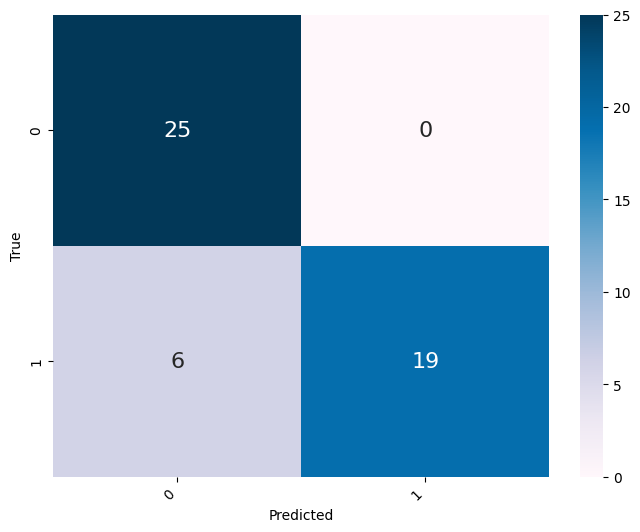

In [34]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion)
df_cm.index.name = 'True'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8, 6))
# sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="PuBu", annot=True,annot_kws={"size": 16}, fmt='d')
plt.xticks(rotation=45, ha='right')


plt.savefig(f"{loc}/Figures/{Exp}_CM.jpg", bbox_inches='tight', dpi=300)
plt.show()

In [35]:
# Calculate overall accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Calculate Cohen's kappa (Kappa)
kappa = cohen_kappa_score(y_true, y_pred)

# Calculate average accuracy (AA)
accuracies = []
for i in range(len(Counter(np.array(y_pred)))):
    accuracies.append(accuracy_score(y_true[y_true==i], y_pred[y_true==i]))
aa = sum(accuracies) / len(accuracies)

# # Matthew’s correlation coefficient
# print("Matthew’s correlation coefficient: %.3f"%matthews_corrcoef(y_true, y_pred))


print("Overall Accuracy (OA): {:.2f}%".format(oa*100))
print("Cohen's Kappa: {:.4f}%".format(kappa*100))
print("Average Accuracy (AA): {:.2f}%".format(aa.mean()*100))

Overall Accuracy (OA): 88.00%
Cohen's Kappa: 76.0000%
Average Accuracy (AA): 88.00%


In [36]:
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = tn / (tn + fp)
f1 = f1_score(y_true, y_pred)

# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 1.0000
Recall (Sensitivity): 0.7600
Specificity: 1.0000
F1 Score: 0.8636


**What could be done more:**
- A more comprehensive analysis could be done using the whole dataset to see how the model performs.
- Choosing different embedding and ansatze to solve the problem and comparing the approaches.
- Choosing other classes as well.

# References
---

- [Daniel Bacioiu, Geoff Melton, Mayorkinos Papaelias, Rob Shaw,
Automated defect classification of Aluminium 5083 TIG welding using HDR camera and neural networks,
Journal of Manufacturing Processes,
Volume 45,
2019,
Pages 603-613,
ISSN 1526-6125,
https://doi.org/10.1016/j.jmapro.2019.07.020.
(https://www.sciencedirect.com/science/article/pii/S1526612519302245)
Abstract: Weld defect identification represents one of the most desired goals in the field of non-destructive testing (NDT) of welds. The current study investigates a system for assessing tungsten inert gas (TIG) welding using a high dynamic range (HDR) camera with the help of artificial neural networks (ANN) for image processing. This study proposes a new dataset11https://www.kaggle.com/danielbacioiu/tig-aluminium-5083. of images of the TIG welding process in the visible spectrum with improved contrast, similar to what a welder would normally see, and a model for computing a label identifying the welding imperfection. The progress (accuracy) achieved with the new system over varying degrees of categorisation complexity is thoroughly presented.
Keywords: Automation; Convolutional neural networks; HDR camera; Vision; Process monitoring; Quality assessment](https://www.sciencedirect.com/science/article/abs/pii/S1526612519302245)

**By -**

Name: Asadullah Bin Rahman 

Email: [galib.cse.17020221@std.hstu.ac.bd](galib.cse.17020221@std.hstu.ac.bd) 

[Portfolio](https://asadullahgalib007.github.io/), [LinkedIn](https://www.linkedin.com/in/asadullah-bin-rahman/), [Google Scholar](https://scholar.google.com/citations?user=mhuUG2oAAAAJ&hl=en)